# Introduction



## Domain Background
- Social networks represent how entities connect and interact, forming complex structures of relationships.

- In the context of Facebook page-page networks, the nodes are public pages (companies, government orgs, politicians, TV shows) and edges represent mutual "likes" between them.

- These connections often reveal shared interests, topical similarity, or strategic alignment between pages. Studying such networks helps uncover communities, influence patterns, and hompohily, offering insights into how information and popularity spread across different categories of pages.

## Dataset Description

The dataset used in this project is the Facebook Large Page-Page Network from the Stanford Large Network Dataset Collection (SNAP). The network was collected through the Facebook Graph API in November 2017.

Dataset Info:

- 22,470 nodes (verified Facebook pages)
- 171,002 undirected edges (mutual 'likes' between pages)
- Four node labels (Facebook-defined categories) - supports multi-class node classficiation
    1. Politicians
    2. Government Organizations
    3. TV Shows
    4. Companies
- Node features extracted from site descriptions that the page owners created to summarize the purpose of the site.
- No edge features.

Citation:

- B. Rozemberczki, C. Allen and R. Sarkar. Multi-scale Attributed Node Embedding. 2019.


## Research Questions

1. Do Facebook pages tend to connect more often with other pages from the same category (e.g., politician-to-politician, brand-to-brand)?

2. Which Facebook pages connect different types of communities together (acting as structural bridges), and what kind of pages are they (e.g., media outlets, celebrities, organizations)?

3. Does the network show signs of structural balance — for example, do pages that both like a third page also tend to like each other?

# Methods

## Overview


Our analysis focused on three main aspects of the Page-Page network. First, we examined homophily, testing whether pages are more likely to connect with other in the same category. Then, we identified bridging pages that connect otherwise separate communities by analyzing centrality and community structure. Finally, we explored structural balance by checking whether pages that like same targets also tend to connect with each other. All the analyses were implemented in Julia using standard network analysis libraries and visualization tools.

### Computational Approach
  1. Data Preprocessing
      - Load data and drop self-loops/duplicate undirected edges.
      - Build an undirected simple graph
      - Keep/label nodes with missing category as “Unknown.”

  2. Homophily Analysis
      - Created a category-to-category mixing matrix.
      - Calculated assortativity to measure how often pages connect within same category.
      - Compared results to a random baseline by shuffling category labels.

  3. Structural Bridge Analysis
      - Applied community detection (Louvain/Leiden) to identify page clusters.
      - Calculated betweenness centrality and participation coefficients.
      - Highlighted pages with high cross-community connections as structural bridges.

  4. Structural Balance / Triadic Closure
      - Measured clustering and triangle formation across the network.
      - Calculated how often pages with common neighbors were also connected.
      - Compared closure levels to a random baseline.

## Data Preprocessing

In [ ]:
# Data Preprocessing
include("src/preprocessing.jl")

data = NetworkPreprocessing.preprocess("data/musae_facebook_edges.csv",
                  "data/musae_facebook_target.csv",
                  "data/musae_facebook_features.json")

g            = data.g
labels       = data.labels
label_code   = data.label_code
label_levels = data.label_levels
X            = data.X
K            = data.K
targets_df   = data.targets_df

Row,id,facebook_id,page_name,page_type
,Int64,Int64,String,String15
1,0,145647315578475,The Voice of China 中国好声音,tvshow
2,1,191483281412,U.S. Consulate General Mumbai,government
3,2,144761358898518,ESET,company
4,3,568700043198473,Consulate General of Switzerland in Montreal,government
5,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician
6,5,134464673284112,Victor Dominello MP,politician
7,6,282657255260177,Jean-Claude Poissant,politician
8,7,239338246176789,Deputado Ademir Camilo,politician
9,8,544818128942324,T.C. Mezar-ı Şerif Başkonsolosluğu,government


## Homophily Analysis

In [ ]:
# Homophily Analysis
include("src/homophily.jl")

hom = NetworkMetrics.summarize_homophily(g, label_code, K; label_levels=label_levels)


====== HOMOPHILY SUMMARY ======
Edge homophily (same-category edge share): 0.8853
Random-mixing baseline (Σ pₖ²): 0.2651
Homophily ratio (observed / baseline): 3.339
Assortativity (r): 0.821
Mean node-level homophily: 0.883
Median node-level homophily: 1.0

Per-category internal edge share:
  company: 0.836
  government: 0.915
  politician: 0.868
  tvshow: 0.839



(0.8206200407380531, 0.8853198925203281, 0.2651177250822885, 3.339346293219506)

## Structural Bridge 

In [24]:
include("src/structuralBridge.jl")

result = NetworkBridge.summarize_bridges(g; top_n=15)

top = result.top
membership = result.comms
betweenness_vals = result.btw
participation_coeff = result.pc

┌ Warning: CommunityDetection.jl not found; using Graphs.label_propagation
└ @ Main.NetworkBridge /workspaces/project1/src/structuralBridge.jl:19


Nodes: 22470   Edges: 170823   Communities: 900
Betweenness: mean=0.0002  max=0.1158

Top 15 structural bridges (high betweenness + high participation):
15×5 DataFrame
 Row │ node   community  betweenness  participation  bridge_score 
     │ Int64  Int64      Float64      Float64        Float64      
─────┼────────────────────────────────────────────────────────────
   1 │   702         10    0.11579         0.866066       94.973
   2 │ 11004         10    0.0896283       0.842373       73.9549
   3 │ 21730         10    0.03982         0.627414       33.2688
   4 │ 19744         10    0.0398052       0.624059       33.2437
   5 │ 21121         29    0.0259536       0.653417       22.2806
   6 │ 17984         10    0.0226966       0.697694       19.8502
   7 │  8483         10    0.0195573       0.631483       17.0782
   8 │ 20416         87    0.0193082       0.364375       15.8253
   9 │ 22172          2    0.0176409       0.672066       15.7055
  10 │ 10380          2    0.015456   

22470-element Vector{Float64}:
 0.0
 0.3460207612456748
 0.0
 0.17999999999999994
 0.598231449442522
 0.24380165289256195
 0.21875
 0.0
 0.4444444444444444
 0.0
 ⋮
 0.5800000000000001
 0.0
 0.0
 0.6782006920415224
 0.0
 0.0
 0.20761245674740492
 0.0
 0.24489795918367352

## Structural Balance

In [13]:
include("src/structuralBalance.jl")

balance_stats = NetworkBalance.structural_balance_summary(g, label_code; R=50)

====== STRUCTURAL BALANCE SUMMARY ======
Triangles (closed triads):            794953
Balanced triads ratio:                0.9991

Friend-of-friend positive closure:
  Qualifying wedges (A–B, A–C +pos):  8462510
  Closed positive wedges (B–C +pos):  2215872
  Closure rate (observed):            0.2618



(n_triads = 794953, balance_ratio = 0.9991408297094294, fof_pos_closure = 0.2618457171690196, fof_baseline_mean = NaN, fof_baseline_std = NaN, fof_lift = NaN, fof_zscore = NaN)

# Results

## Homophily

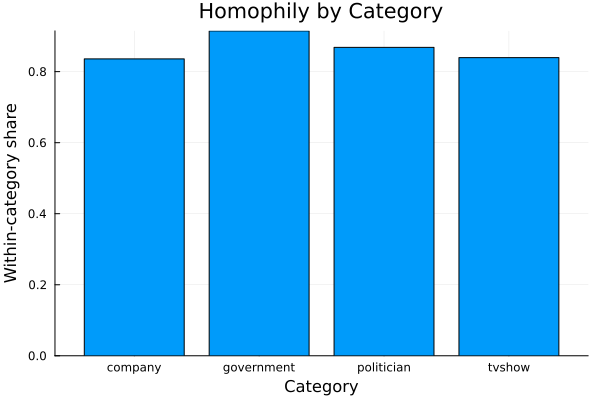

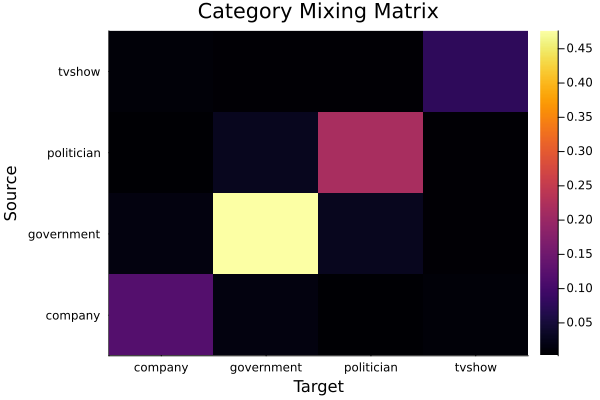

In [17]:
using Plots, LinearAlgebra, StatsBase

# assume: g, label_code, K, label_levels already defined
e = NetworkMetrics.categorical_mixing_matrix(g, label_code, K)
names = String.(collect(label_levels))

# per-category internal share
percat = [e[i,i] / sum(e[i,:]) for i in 1:K]

# bar chart
bar(names, percat, title="Homophily by Category",
    xlabel="Category", ylabel="Within-category share", legend=false)
display(current())

# heatmap
heatmap(e, xticks=(1:K, names), yticks=(1:K, names),
        title="Category Mixing Matrix", xlabel="Target", ylabel="Source")

## Structural Bridge

In [ ]:
using GraphPlot, Graphs, Plots, Colors

palette = distinguishable_colors(length(unique(membership)))
sizes = 5 .+ 15 .* (betweenness_vals .- minimum(betweenness_vals)) ./ (maximum(betweenness_vals) - minimum(betweenness_vals) + eps())

# 1) Use a fast layout (spectral) instead of the default spring layout
gplot(g;
    layout = spectral_layout,              # much faster
    nodefillc = [palette[membership[v]] for v in 1:nv(g)],
    nodesize  = sizes,
    nodelabel = false,
    title     = "Communities (size = betweenness)"
)
display(current())

# 2) Scatter is already fast
scatter(betweenness_vals, participation_coeff;
    group  = membership,
    xlabel = "Betweenness", ylabel = "Participation",
    title  = "Bridging Nodes", legend = false
)

## Structural Balance

# Discussion

# Conclusion